## Семинар 2 "Распознавание рукописных цифр"

ФИО: Елохов Артур Владимирович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import scipy
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,8)

In [2]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

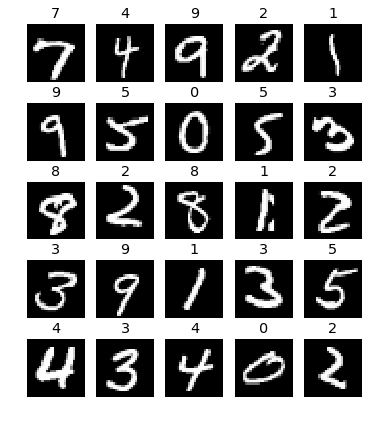

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [5]:
class Linear:
    def __init__(self, input_size, output_size):
        loc = 0
        scale = 0.1
        W = np.random.normal(loc, scale, (input_size, output_size))
        self.W = np.concatenate((W, np.zeros((1, W.shape[1]))))
        return
    
    def forward(self, X):
        self.X = np.concatenate((X, -np.ones((X.shape[0],1))), axis=1)
        Y = np.dot(self.X, self.W)
        return Y
    
    def backward(self, dLdy):
        dLdw = (np.dot(dLdy.T, self.X)).T
        dLdx = np.dot(dLdy, self.W.T)
        self.dLdw = dLdw
        return dLdx[:,:-1]
    
    def step(self, learning_rate):
        self.W = self.W - learning_rate * self.dLdw
        return

In [6]:
class Sigmoid:
    def __init__(self):
        pass
    
    def sigmoid(self, z):
        return 1.0/(1.0 + np.exp(-z))
    
    def forward(self, X):
        Y = self.sigmoid(X)
        self.X = X
        return Y
    
    def backward(self, dLdy):
        dydx = self.sigmoid(self.X) * (1 - self.sigmoid(self.X))
        dLdx = dLdy * dydx
        return dLdx
    
    def step(self, learning_rate):
        pass

In [7]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        Y = np.maximum(X, np.zeros(X.shape))
        self.X = X
        return Y
    
    def backward(self, dLdy):
        dydx = (self.X > 0).astype(int)
        dLdx = dLdy * dydx
        return dLdx
    
    def step(self, learning_rate):
        pass

In [8]:
class ELU:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        pass
    
    def forward(self, X):
        Y = np.maximum(X, np.zeros(X.shape)) + self.alpha * (np.exp(np.minimum(np.zeros(X.shape), X)) - 1)
        self.X = X
        return Y
    
    def backward(self, dLdy):
        dydx = (self.X > 0).astype(int) + (self.X < 0).astype(int) * self.alpha * np.exp(np.minimum(np.zeros(self.X.shape), self.X))
        dLdx = dLdy * dydx
        return dLdx
    
    def step(self, learning_rate):
        pass

In [9]:
class NLLLoss:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        N = X.shape[0]
        d = X.shape[1]
        a = np.reshape(np.max(X, axis=1), (N, 1))
        self.indicator = (np.array([ k * np.ones(N) for k in xrange(d)]) == y).astype(int).T
        L = np.sum((self.indicator * (a - X + (np.log(np.sum(np.exp(X - a), axis=1))).reshape((N, 1)))), axis=1)
        self.X = X
        self.a = a
        return np.sum(L)/N
    
    def backward(self):
        dLdx = -1 * self.indicator + np.exp(self.X - self.a)/np.sum(np.exp(self.X - self.a), axis=1).reshape((self.X.shape[0], 1))
        return dLdx

In [10]:
class NeuralNetwork:
    def __init__(self, modules):
        self.modules = modules
        self.Loss = NLLLoss()
        return
    
    def forward(self, X):
        for module in self.modules:
            X = module.forward(X)
        return X
    
    def backward(self, dLdy):
        for module in reversed(self.modules):
            dLdy = module.backward(dLdy)
        return dLdy
    
    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate)
        return
    
    def train(self, X, y, Epoch=100, learning_rate=0.01, verbose=False):
        self.Loss_train = []
        for epoch in xrange(Epoch):
            result = self.forward(X)
            loss = self.Loss.forward(result, y)
            if(verbose and (epoch % 100 == 99)):
                print "Epoch: %d; Loss: %f" %(epoch, loss)
            self.Loss_train.append(loss)
            self.backward(self.Loss.backward())
            self.step(learning_rate)  
        return np.argmax(result, axis=1)
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)
    
    def loss_plot(self, Epoch):
        axis_x = np.arange(0, Epoch)
        axis_y = np.array(self.Loss_train)
        plt.figure()
        plt.plot(axis_x, axis_y)
        plt.xlabel('Epoch')
        plt.ylabel('NLL')
        plt.show()
        return

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
def loss_and_accuracy(Clf, train, test, Epoch=10, learning_rate=0.001):
    Loss_train = []
    Loss_test = []
    for epoch in xrange(Epoch):
        L_train = []
        L_test = []
        for X, y in train:
            X = X.view(X.size(0), -1)
            X = X.numpy()
            y = y.numpy()
            loss = Clf.Loss.forward(Clf.forward(X), y)
            Clf.backward(Clf.Loss.backward())
            Clf.step(learning_rate)
            L_train.append(loss)
        for X, y in test:
            X = X.view(X.size(0), -1)
            X = X.numpy()
            y = y.numpy()
            loss = Clf.Loss.forward(Clf.forward(X), y)
            L_test.append(loss)
        Loss_test.append(sum(L_test)/len(L_test))    
        Loss_train.append(sum(L_train)/len(L_train))
        
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(Loss_train)
    axis_y2 = np.array(Loss_test)
    plt.figure()
    plt.plot(axis_x, axis_y1, linewidth=2.0)
    plt.plot(axis_x, axis_y2, linewidth=2.0)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.legend(['train', 'test'])
    plt.show()
    Scores = []
    for X, y in test:
        X = X.view(X.size(0), -1)
        X = X.numpy()
        y = y.numpy()
        y_predicted = Clf.predict(X)
        Scores.append(accuracy_score(y, y_predicted))
    print "Accuracy: %f" %(sum(Scores)/len(Scores))
    return

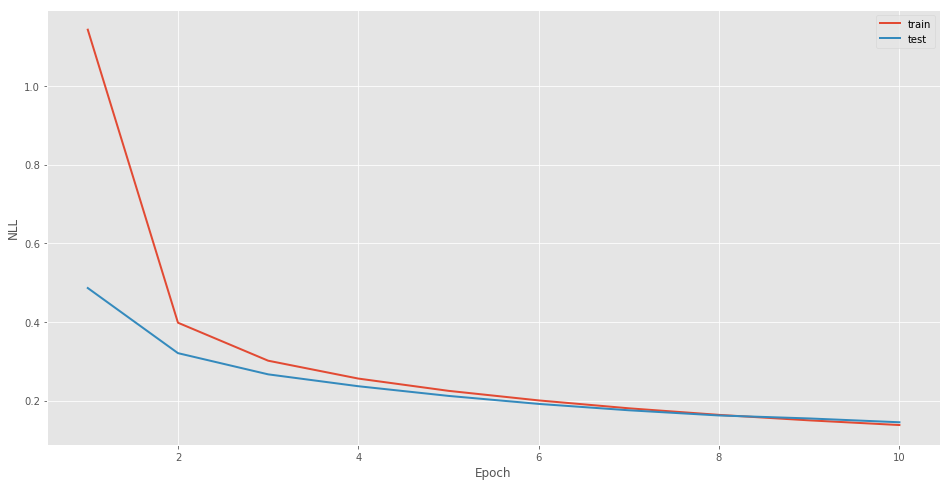

Accuracy: 0.958566


In [13]:
Clf = NeuralNetwork((Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)))
loss_and_accuracy(Clf, train_loader, test_loader)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

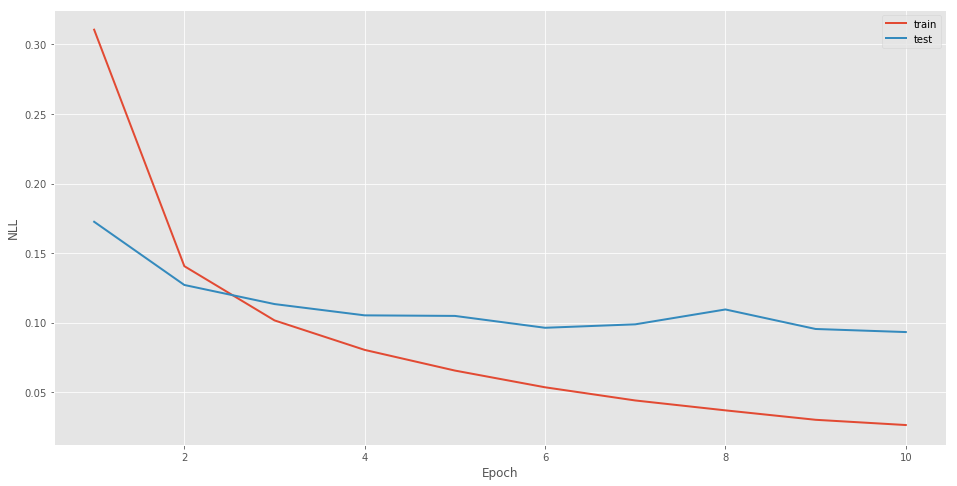

Accuracy: 0.973542


In [14]:
Clf = NeuralNetwork((Linear(784, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 10)))
loss_and_accuracy(Clf, train_loader, test_loader)

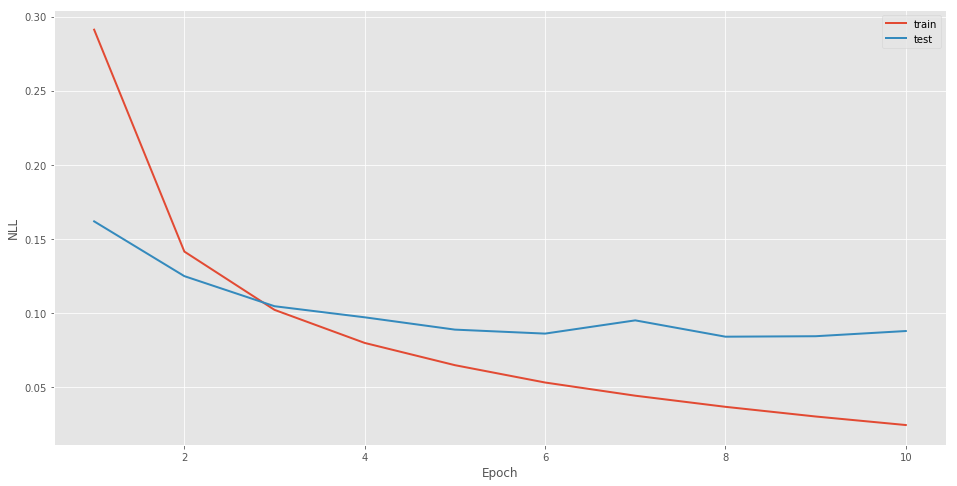

Accuracy: 0.974940


In [15]:
Clf = NeuralNetwork((Linear(784, 100), ELU(), Linear(100, 100), ELU(), Linear(100, 10)))
loss_and_accuracy(Clf, train_loader, test_loader)

ReLU и ELU показали лучшую скорость и точность, чем сигмоида

### Часть 3: Предобработка данных

Посчитайте на всей обучающей выборке матрицу ковариации и среднее. Нормализуйте данные по схеме: вычесть среднее, декоррелировать, нормировать дисперсию. Сравните графики обучения на одной и той же архитектуре с и без предобработки.

In [16]:
Train = []
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy()
    y = y.numpy()
    Train.append([X, y])
    
Test = []
for X, y in test_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy()
    y = y.numpy()
    Test.append([X, y])

In [17]:
X = Train[0][0]
y = Train[0][1]
for i in xrange(len(Train) - 1):
    X = np.concatenate((X, Train[i + 1][0]))
    y = np.concatenate((y, Train[i + 1][1]))
print X.shape

(60000, 784)


In [18]:
X_mean = np.mean(X, axis=0)

In [19]:
X_std = np.std(X, axis=0)

In [20]:
X_cov = np.cov(X, rowvar=False)
I = np.eye(X_cov.shape[0])
lambd = 0.78
X_cov += lambd * I
X_cov_inv_sqrt = scipy.linalg.sqrtm(np.linalg.inv(X_cov))

In [25]:
def loss_and_accuracy_norm(Clf, train, test, X_mean, X_cov_inv_sqrt, X_std, Epoch=10, learning_rate=0.001):
    Loss_train = []
    Loss_test = []
    eps = 0.0001
    X_std += eps
    for epoch in xrange(Epoch):
        L_train = []
        L_test = []
        for X, y in train:
            X = X.view(X.size(0), -1)
            X = X.numpy()
            y = y.numpy()
            #normalization
            X -= X_mean
            X = np.dot(X_cov_inv_sqrt, X.T).T
            X /= X_std + eps
            loss = Clf.Loss.forward(Clf.forward(X), y)
            Clf.backward(Clf.Loss.backward())
            Clf.step(learning_rate)
            L_train.append(loss)
        for X, y in test:
            X = X.view(X.size(0), -1)
            X = X.numpy()
            y = y.numpy()
            #normalization
            X -= X_mean
            X = np.dot(X_cov_inv_sqrt, X.T).T
            X /= X_std + eps
            loss = Clf.Loss.forward(Clf.forward(X), y)
            L_test.append(loss)
        Loss_test.append(sum(L_test)/len(L_test))    
        Loss_train.append(sum(L_train)/len(L_train))
        
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(Loss_train)
    axis_y2 = np.array(Loss_test)
    plt.figure()
    plt.plot(axis_x, axis_y1, linewidth=2.0)
    plt.plot(axis_x, axis_y2, linewidth=2.0)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.legend(['train', 'test'])
    plt.show()
    Scores = []
    for X, y in test:
        X = X.view(X.size(0), -1)
        X = X.numpy()
        y = y.numpy()
        #normalization
        X -= X_mean
        X = np.dot(X_cov_inv_sqrt, X.T).T
        X /= X_std + eps
        y_predicted = Clf.predict(X)
        Scores.append(accuracy_score(y, y_predicted))
    print "Accuracy: %f" %(sum(Scores)/len(Scores))
    return

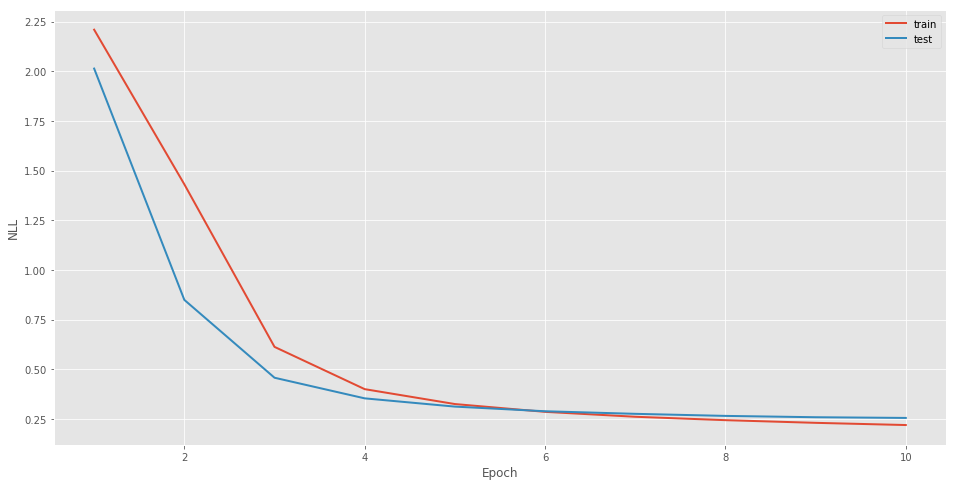

Accuracy: 0.926917


In [26]:
Clf = NeuralNetwork((Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)))
loss_and_accuracy_norm(Clf, train_loader, test_loader, X_mean, X_cov_inv_sqrt, X_std)

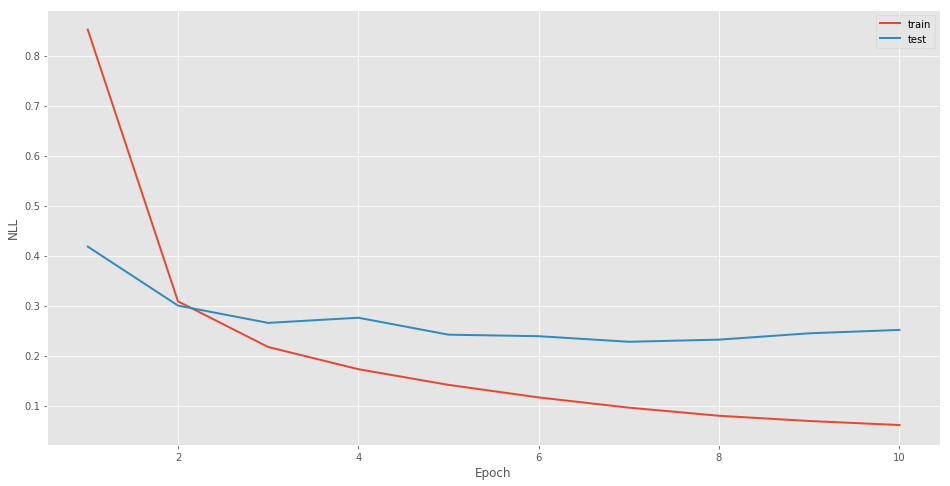

Accuracy: 0.945487


In [27]:
Clf = NeuralNetwork((Linear(784, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 10)))
loss_and_accuracy_norm(Clf, train_loader, test_loader, X_mean, X_cov_inv_sqrt, X_std)

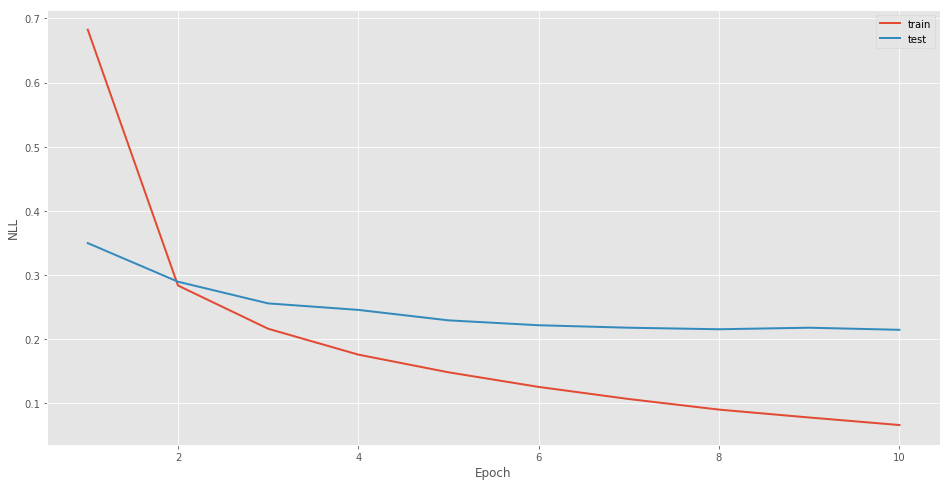

Accuracy: 0.950579


In [28]:
Clf = NeuralNetwork((Linear(784, 100), ELU(), Linear(100, 100), ELU(), Linear(100, 10)))
loss_and_accuracy_norm(Clf, train_loader, test_loader, X_mean, X_cov_inv_sqrt, X_std)

### Часть 4: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Выбор нелинености может немного увеличить скорость сходимости и качество классификации. Предобработка данных не улучшила качество классификации. Скорость сходимости сигмоиды увеличилась. Предобработку нужно делать осторожно, т.к. деление на маленькую дисперсию может привести к переполнению.